# Parcel rollup

This notebook demonstrates how to pull data from the AI features API on a per parcel basis, filter out features we do not not consider part of the parcels, and to transform (rollup) the data into a tabular format.

In [1]:
# Use Black to enforce style in the notebook, use `pip install nb_black` to install.
# https://pypi.org/project/nb-black/
# May not work with Jupyter Lab
%load_ext nb_black
# Reload packages to always use latest
%matplotlib inline
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import concurrent.futures
import json
import os
from pathlib import Path
import shutil
import time
import logging

from descartes import PolygonPatch
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, shape
import shapely.wkt
from tqdm import tqdm

# Local utilities
import utils

# Projections CRS strings
SOURCE_CRS = "EPSG:4326"
ALBERS_CRS = "esri:102003"

# Logging level - set this to determine what level of info is returned. "INFO" adds timings for API responses.
logging.root.setLevel(logging.WARNING)

pd.set_option("max_columns", 100)
pd.set_option("max_rows", 500)

<IPython.core.display.Javascript object>

## API params

### Which AI Packs and Feature Classes to use?

The following cell controls which class IDs are used (anything not in `ALL_USED_IDS` is ignored). It starts to look very cluttered with all packs, so a subset of these (`VISUALISATION_IDS`) is used for the visualisation of examples.

The source of truth for feature class IDs is the "classes.json" endpoint of the API, which can be refreshed periodically to add new feature class IDs to existing packs, update any changed descriptions, or reflect any new AI Packs added to your subscription.

### Date Restrictions
`SINCE` and `UNTIL` allow a generic restriction of dates. The latest published AI results within that time window will be returned.

In [3]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

# Data date range
SINCE, UNTIL = ("2016-01-01", "2022-12-31")

# Get pack codes from https://api.nearmap.com/ai/features/v4/packs.json
PACKS = ",".join(
    [
        "building",
        "building_char",
        "roof_char",
        "solar",
        "construction",
        "trampoline",
        "pool",
        "vegetation",
        "surfaces",
    ]
)

# Number of concurrent workers
THREADS = 10
CHUNK_SIZE = 100
PROCESSES = 10

BUILDING_ID = "a2e4ae39-8a61-5515-9d18-8900aa6e6072"
ROOF_ID = "c08255a4-ba9f-562b-932c-ff76f2faeeeb"

TRAMPOLINE_ID = "753621ee-0b9f-515e-9bcf-ea40b96612ab"
POOL_ID = "0339726f-081e-5a6e-b9a9-42d95c1b5c8a"
CONSTRUCTION_ID = "a2a81381-13c6-57dc-a967-af696e45f6c7"
SOLAR_ID = "3680e1b8-8ae1-5a15-8ec7-820078ef3298"

VEG_VERYLOW_ID = "a7d921b7-393c-4121-b317-e9cda3e4c19b"
VEG_LOW_ID = "2780fa70-7713-437c-ad98-656b8a5cc4f2"
VEG_MEDHIGH_ID = "dfd8181b-80c9-4234-9d05-0eef927e3aca"
VEG_IDS = [VEG_VERYLOW_ID, VEG_LOW_ID, VEG_MEDHIGH_ID]

DIRT_GRAVEL_SAND_ID = "0ad1355f-5dfd-403b-8b8b-b7d8ed95731f"
WATER_BODY_ID = "2e0bd9e3-3b67-4990-84dc-1b4812fdd02b"
CONCRETE_ID = "290897be-078b-4948-97aa-755289a67a29"
ASPHALT_ID = "97a1f8a8-7cf2-4e81-82b4-753ee225d9ed"
LAWN_GRASS_ID = "68dc5061-5842-4a17-8073-e278a91b607d"
SURFACES_IDS = [
    WATER_BODY_ID,
    CONCRETE_ID,
    ASPHALT_ID,
    LAWN_GRASS_ID,
    DIRT_GRAVEL_SAND_ID,
]

METAL_ROOF_ID = "4424186a-0b42-5608-a5a0-d4432695c260"
TILE_ROOF_ID = "516fdfd5-0be9-59fe-b849-92faef8ef26e"
SHINGLE_ROOF_ID = "4bbf8dbd-cc81-5773-961f-0121101422be"
FLAT_ROOF_ID = "224f98d3-b853-542a-8b18-e1e46e3a8200"
HIP_ROOF_ID = "ac0a5f75-d8aa-554c-8a43-cee9684ef9e9"
GABLE_ROOF_ID = "59c6e27e-6ef2-5b5c-90e7-31cfca78c0c2"
DUTCH_GABLE_ROOF_ID = "3719eb40-d6d1-5071-bbe6-379a551bb65f"
TURRET_ROOF_ID = "89582082-e5b8-5853-bc94-3a0392cab98a"
TREE_OVERHANG_ID = "8e9448bd-4669-5f46-b8f0-840fee25c34c"
ROOF_CHAR_IDS = [
    METAL_ROOF_ID,
    TILE_ROOF_ID,
    SHINGLE_ROOF_ID,
    FLAT_ROOF_ID,
    HIP_ROOF_ID,
    GABLE_ROOF_ID,
    DUTCH_GABLE_ROOF_ID,
    TURRET_ROOF_ID,
    TREE_OVERHANG_ID,
]

<IPython.core.display.Javascript object>

In [4]:
ALL_USED_IDS = (
    [BUILDING_ID, ROOF_ID, TRAMPOLINE_ID, POOL_ID, CONSTRUCTION_ID, SOLAR_ID]
    + VEG_IDS
    + SURFACES_IDS
    + ROOF_CHAR_IDS
)
VISUALISATION_IDS = [
    BUILDING_ID,
    ROOF_ID,
    TRAMPOLINE_ID,
    POOL_ID,
    CONSTRUCTION_ID,
    SOLAR_ID,
] + VEG_IDS

<IPython.core.display.Javascript object>

In [5]:
df_classes = utils.get_feature_class_ids(API_KEY).set_index("id").loc[ALL_USED_IDS, :]
df_classes

,type,description,schema
id,,,
a2e4ae39-8a61-5515-9d18-8900aa6e6072,Feature,Building,NaN
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Feature,Roof,NaN
753621ee-0b9f-515e-9bcf-ea40b96612ab,Feature,Trampoline,NaN
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,Swimming Pool,NaN
a2a81381-13c6-57dc-a967-af696e45f6c7,Feature,Construction Site,NaN
3680e1b8-8ae1-5a15-8ec7-820078ef3298,Feature,Solar Panel,NaN
a7d921b7-393c-4121-b317-e9cda3e4c19b,Feature,Very Low Vegetation (<0.5m),NaN
2780fa70-7713-437c-ad98-656b8a5cc4f2,Feature,Low Vegetation (0.5m-2m),NaN
dfd8181b-80c9-4234-9d05-0eef927e3aca,Feature,Medium & High Vegetation (>2m),NaN


<IPython.core.display.Javascript object>

## File system params
Paths for input query AOIs (usually property parcel boundaries), the cache, and output location.

In [6]:
PARCELS_PATH = Path("../data/parcels/parcel_sample_chicago.csv")
RESPONSE_DIR = Path("../data/response_cache")
OUTPUT_PATH = Path("../data/processed/parcel_sample_chicago.csv")

<IPython.core.display.Javascript object>

## Feature filtering params

The features API returns all features intersecting an AOI. Some of these features may not be relevant to our calculations. In the following cell, we define thresholds (per class) to decide which features should be discarded based on feature size, confidence, and the area and ratio of the feature that intersects the AOI.

Refer to the [filter features](#Filter-features) section for more detail on exactly how these are used.

In [7]:
# Min sizes are in squared meters
MIN_SIZES = {
    BUILDING_ID: 16,
    TRAMPOLINE_ID: 9,
    POOL_ID: 9,
    CONSTRUCTION_ID: 9,
    SOLAR_ID: 9,
}
MIN_SIZES[ROOF_ID] = MIN_SIZES[BUILDING_ID]

# Min confidence values
MIN_CONFIDENCES = {
    BUILDING_ID: 0.8,
    TRAMPOLINE_ID: 0.7,
    POOL_ID: 0.7,
    CONSTRUCTION_ID: 0.8,
    SOLAR_ID: 0.7,
}
MIN_CONFIDENCES[ROOF_ID] = MIN_CONFIDENCES[BUILDING_ID]

# Min area and ratio in parcel.
# Logic is set up to keep a feature if either one of the area and ratio limits are met.
MIN_AREA_IN_PARCEL = {
    BUILDING_ID: 16,
    TRAMPOLINE_ID: 5,
    POOL_ID: 5,
    CONSTRUCTION_ID: 5,
    SOLAR_ID: 5,
}
MIN_AREA_IN_PARCEL[ROOF_ID] = MIN_AREA_IN_PARCEL[BUILDING_ID]
MIN_RATIO_IN_PARCEL = {
    BUILDING_ID: 0.5,
    TRAMPOLINE_ID: 0.5,
    POOL_ID: 0.5,
    CONSTRUCTION_ID: 0.5,
    SOLAR_ID: 0.5,
}
MIN_RATIO_IN_PARCEL[ROOF_ID] = MIN_RATIO_IN_PARCEL[BUILDING_ID]

<IPython.core.display.Javascript object>

### SHOULD I CLEAR THE CACHE?
WARNING: this clears the cache. PLEASE CONFIRM YOU HAVE STORED ANY PAYLOADS SAFELY PRIOR TO DOING THIS!!! Otherwise, you may lose data you have downloaded.

Cache is keyed by the `id` field of the query AOIs, the `since` and `until` dates. If fresh AI results are published that fall within that window, repeating the same pull (after deleting the cache) may have different results.


In [8]:
CLEAR_CACHE = False

if CLEAR_CACHE:
    shutil.rmtree(RESPONSE_DIR, ignore_errors=True)

RESPONSE_DIR.mkdir(parents=True, exist_ok=True)
# Create output directory if it doesn't exist
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

# Load Query AOI (parcel) data
A query AOI is the polygon within which a section of our AI vector maps will be returned. This is most commonly used as property parcel boundaries.

We need our query AOI data to have two key fields (but others are also ok):
 - `id`: A unique identifier
 - `geometry`: A geometry (in this case in EPSG 4326)
 
This code works for comma separated `.csv` files, and `.geojson` files.

There is some automated cleanup to:
- Check for duplicate ids (which may indicate a data input issue)
- Drop any rows where the geometry field is empty.

Results are then plotted for an overview.

Number of parcels 2180


,id,properties,geometry,geometry_epsg4326
0,8ced57c8-b42e-57d4-84af-41c7094818fc,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673121.908 503404.629, 673117....","MULTIPOLYGON (((-87.83864 41.73505, -87.83865 ..."
1,fc5d7cdf-d57c-59c6-ba84-60c1763be619,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673162.929 503515.254, 673160....","MULTIPOLYGON (((-87.83803 41.73600, -87.83804 ..."
2,239965dc-fd74-506a-998a-38caddeb1e30,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673064.248 503499.649, 673059....","MULTIPOLYGON (((-87.83924 41.73594, -87.83925 ..."
3,844f2c45-fc7b-509c-bffd-a30e6b6e00fd,"{'state': 'IL', 'county': 'COOK', 'taxapn': '2...","MULTIPOLYGON (((673347.338 503118.105, 673342....","MULTIPOLYGON (((-87.83622 41.73232, -87.83623 ..."
4,cf3d685e-6139-5dda-bf7c-318df0f9888c,"{'state': 'IL', 'county': 'COOK', 'taxapn': '2...","MULTIPOLYGON (((673267.939 503100.113, 673228....","MULTIPOLYGON (((-87.83720 41.73222, -87.83766 ..."


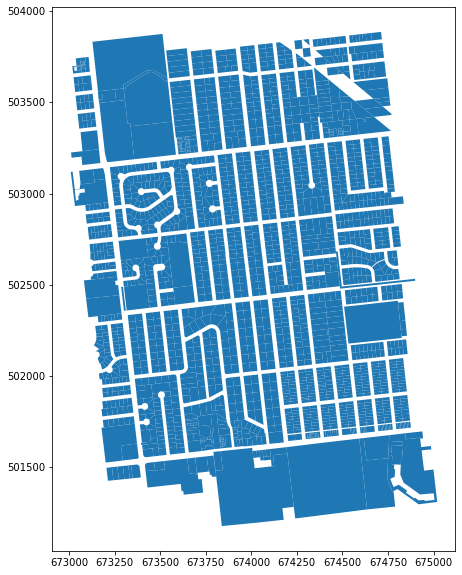

<IPython.core.display.Javascript object>

In [9]:
# Read parcel data set and convert to geopandas dataframe

if PARCELS_PATH.suffix == ".csv":
    parcels_df = pd.read_csv(PARCELS_PATH)
    parcels_gdf = gpd.GeoDataFrame(
        parcels_df.drop("geometry", axis=1),
        geometry=parcels_df.geometry.fillna("POLYGON(EMPTY)").apply(shapely.wkt.loads),
        crs=SOURCE_CRS,
    )
    del parcels_df
elif PARCELS_PATH.suffix in (".geojson", ".gpkg"):
    parcels_gdf = gpd.read_file(PARCELS_PATH)

if parcels_gdf.crs is None:
    parcels_gdf.set_crs(SOURCE_CRS)

# Check that identifier is unique
assert not parcels_gdf.id.duplicated().any()

# Drop any empty geometries
parcels_gdf = parcels_gdf.dropna(subset=["geometry"])
parcels_gdf = parcels_gdf[~parcels_gdf.is_empty]

# Project parcels to Albers equal area (keep EPSG 326 around, we'll need both)
parcels_gdf["geometry_epsg4326"] = parcels_gdf["geometry"]
parcels_gdf = parcels_gdf.to_crs(ALBERS_CRS)

# Show example and plot - map will show blank if small parcels are very spread out
print(f"Number of parcels {len(parcels_gdf)}")
parcels_gdf.plot(figsize=(10, 10))
display(parcels_gdf.head())

# Fetching data from the API

By using a local cache we do not have to make the same request multiple times. This cache forms a repository of all source data downloaded from the API, and should be stored as a record in case of subsequent processing bugs. This means that adjustments can be made to the post processing pipeline without needing to spend additional credits on the API.

In [10]:
def cached_get_payload(parcel_id, geometry, since, until, force=False):
    """
    Get API payload, either from API or from cache
    """
    cache_path = RESPONSE_DIR / f"{parcel_id}_{since}_{until}.json"
    if cache_path.exists() and not force:
        with open(cache_path, "r") as f:
            payload = json.load(f)
    else:
        payload, error = utils.get_features(
            geometry, PACKS, API_KEY, since=since, until=until
        )
        if error:
            return None, error

        with open(cache_path, "w") as f:
            json.dump(payload, f, indent=2)
    return payload, None

<IPython.core.display.Javascript object>

# Create geodataframe

We use geopandas for efficient geo-processing. The examples show features for a few query AOIs. Note how features on the edge of query AOI boundaries are included. All packs except `vegetation` and `surfaces` include any whole objects that intersect with the query AOI. Those are considered "continuous" classes which may include extremely large features such as forests or oceans - so they are clipped to the intersection of the feature and the query AOI boundary.

In [11]:
def create_geodataframe(payload, geometry):
    """
    Convert a payload returned by the features API into a geodataframe.

    Note: Geometries are projected to Albers equal area. Area calculations are therefore in metres squared.
    """
    # Cast geojson to shapely
    for feature in payload["features"]:
        feature["geometry"] = shape(feature["geometry"])

    # Create geodataframe and project to Albers equal area for area based calculations
    if len(payload["features"]) > 0:
        features_gdf = gpd.GeoDataFrame(payload["features"], geometry="geometry")
    else:
        features_gdf = gpd.GeoDataFrame(
            [],
            columns=[
                "classId",
                "areaSqm",
                "areaSqft",
                "confidence",
                "survey_date",
                "geometry",
            ],
        )
    features_gdf = features_gdf.set_crs(SOURCE_CRS)
    features_gdf = features_gdf.to_crs(ALBERS_CRS)

    # Calculate the area of each feature that falls within the parcel
    features_gdf["intersectionArea"] = features_gdf.geometry.intersection(geometry).area
    # Calculate the ratio of a feature that falls within the parcel
    features_gdf["intersectionRatio"] = (
        features_gdf.intersectionArea / features_gdf.area
    )

    return features_gdf

<IPython.core.display.Javascript object>

100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


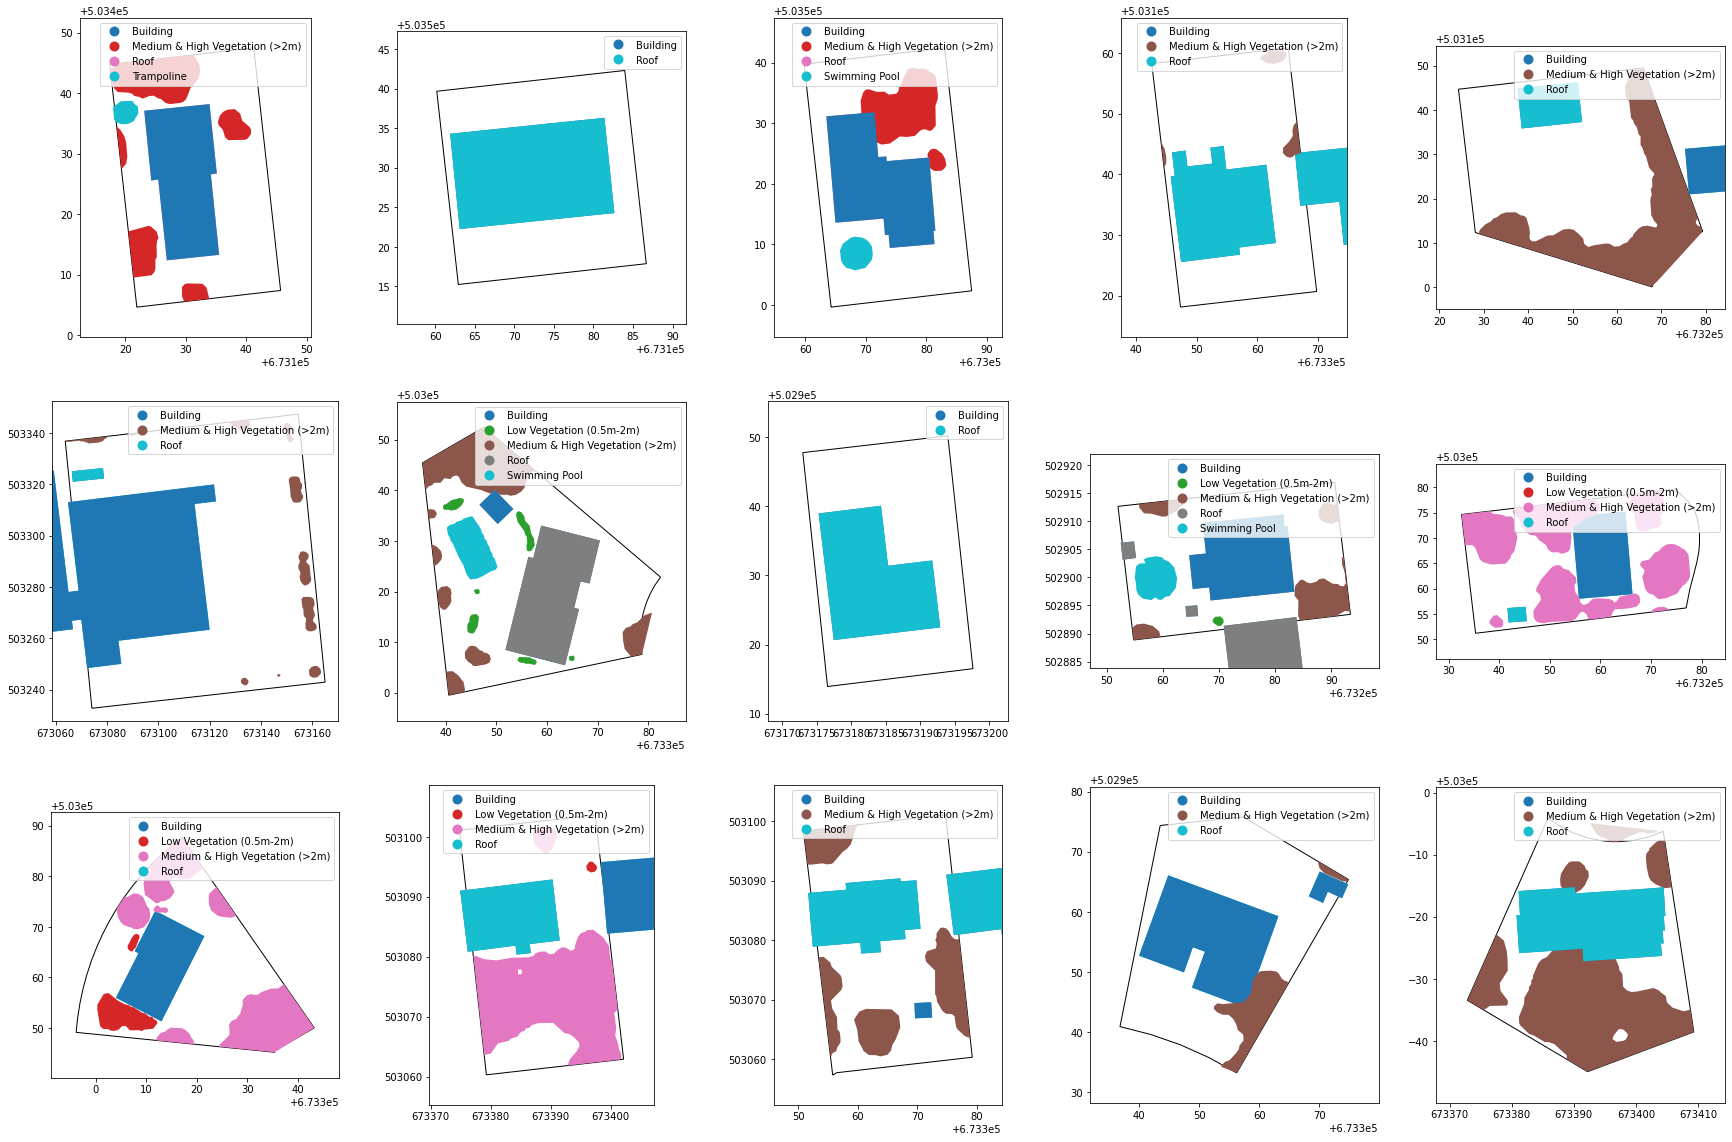

<IPython.core.display.Javascript object>

In [12]:
# Plot a few examples
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
axes = [ax for row in axes for ax in row]
N_EXAMPLES = 15
for i, row in tqdm(parcels_gdf.head(N_EXAMPLES).iterrows(), total=N_EXAMPLES):
    payload, error = cached_get_payload(
        row.id, row.geometry_epsg4326, since=SINCE, until=UNTIL
    )
    if not error:
        features_gdf = create_geodataframe(payload, row.geometry)
        features_gdf.query("classId in @VISUALISATION_IDS").plot(
            ax=axes[i], column="description", legend=True
        )
    else:
        logging.warning(error)
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - 5, row.geometry.bounds[2] + 5)
    axes[i].set_ylim(row.geometry.bounds[1] - 5, row.geometry.bounds[3] + 5)

# Filter features

As seen in the previous examples, there are often features on the edge of parcels that we want to reject, as a slight mismatch may exist between the AI results (in non epoch adjusted EPSG:4326) and the query AOI. This mismatch is most commonly caused by slight parcel boundary location errors. In this notebook we apply four filters:
 - Low area features
 - Low confidence features
 - Features that are mostly outside the parcel, unless there is significant area overlap
 - Feature classes without defined filtering parameters are automatically included if listed in the `ALL_USED_IDS` constant.

In [13]:
def filter_features(features_gdf):
    """
    Filter features based on the defined filtering parameters. Default to keeping anything where feature class ID minimum confidences and sizes are not defined.
    """
    # Filter small features
    features_gdf = features_gdf[
        features_gdf.classId.map(MIN_SIZES).fillna(0) < features_gdf.area
    ]

    # Filter low confidence features
    features_gdf = features_gdf[
        features_gdf.classId.map(MIN_CONFIDENCES).fillna(0) < features_gdf.confidence
    ]
    # Filter based on area and ratio in parcel
    area_mask = (
        features_gdf.classId.map(MIN_AREA_IN_PARCEL).fillna(0)
        < features_gdf.intersectionArea
    )
    ratio_mask = (
        features_gdf.classId.map(MIN_RATIO_IN_PARCEL).fillna(0)
        < features_gdf.intersectionRatio
    )
    features_gdf = features_gdf[area_mask | ratio_mask]

    return features_gdf

<IPython.core.display.Javascript object>

Plot a few examples. Red and black striped features were discarded by the filter parameters chosen above.

100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


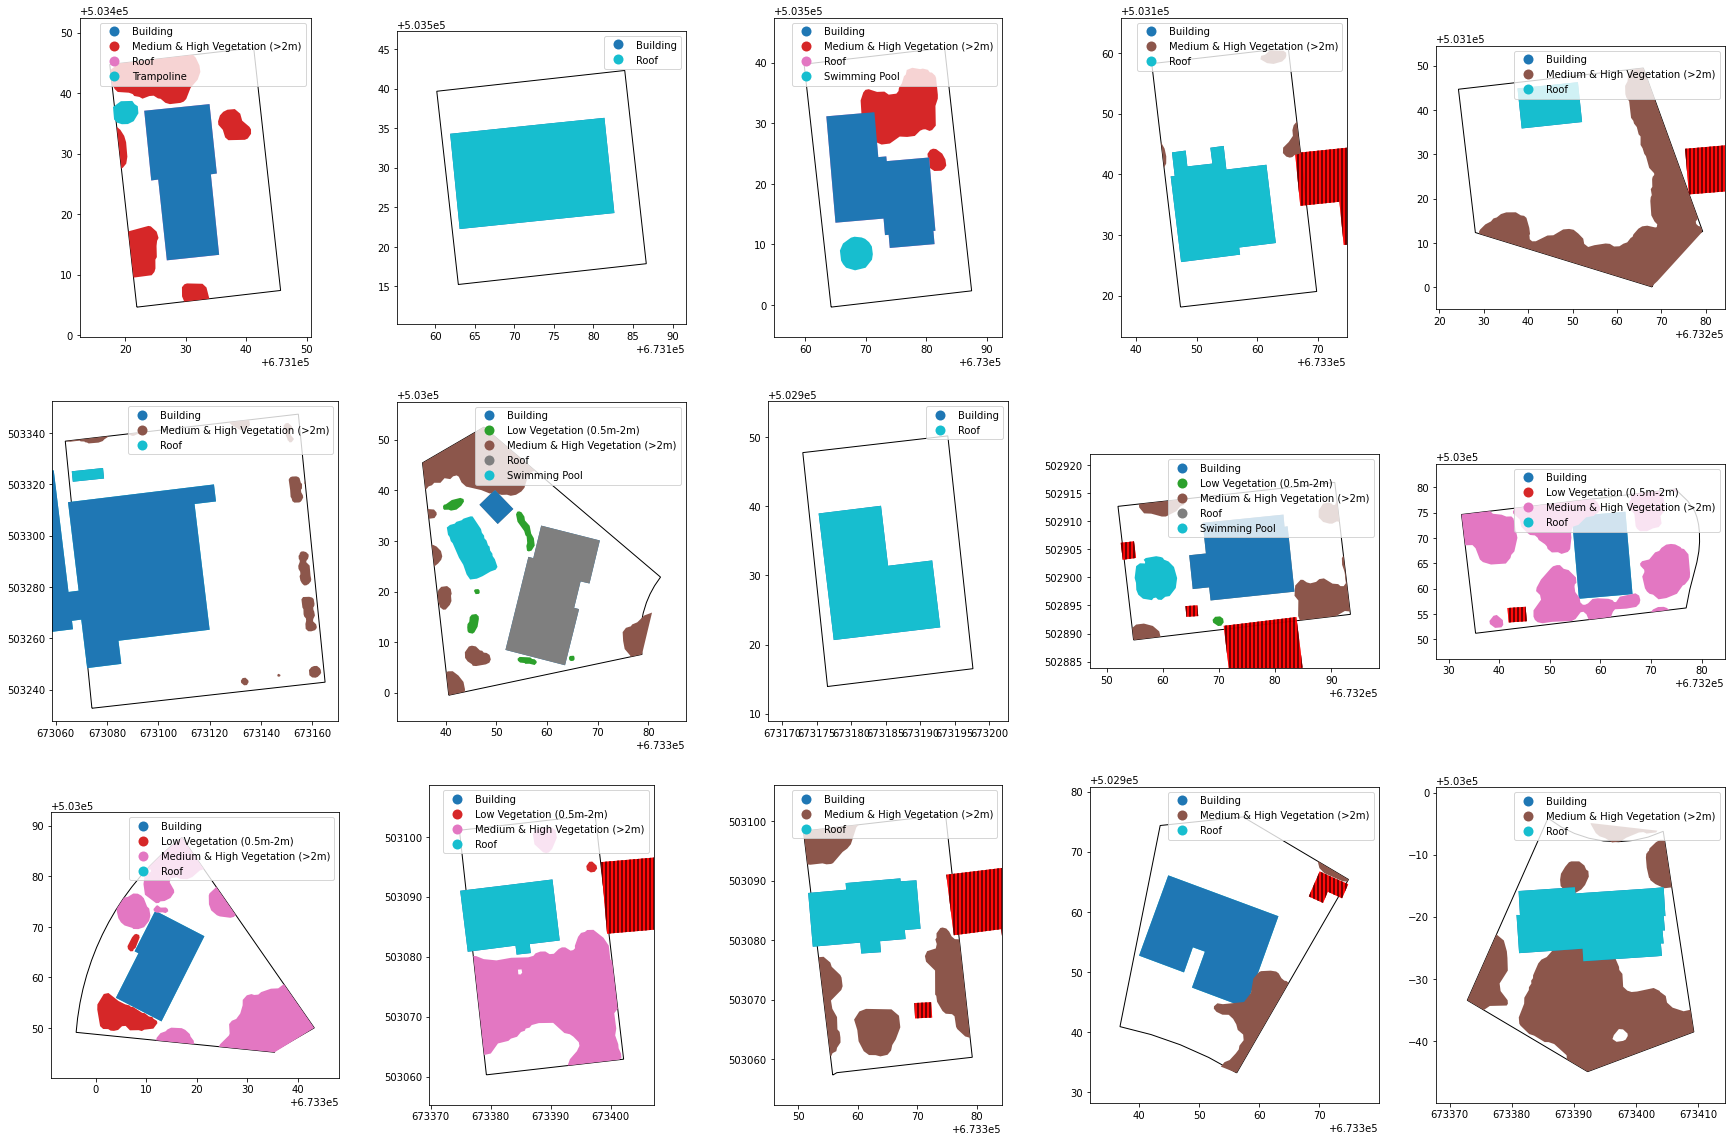

<IPython.core.display.Javascript object>

In [14]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
axes = [ax for row in axes for ax in row]
for i, row in tqdm(parcels_gdf.head(N_EXAMPLES).iterrows(), total=N_EXAMPLES):
    # Get API payload
    payload, error = cached_get_payload(
        row.id, row.geometry_epsg4326, since=SINCE, until=UNTIL
    )

    if not error:
        # Create geo-df
        features_gdf = create_geodataframe(payload, row.geometry)

        # Filter features
        features_gdf_keep = filter_features(features_gdf)
        features_gdf_discard = pd.concat(
            (features_gdf, features_gdf_keep)
        ).drop_duplicates(keep=False, subset="id")

        # Plot all features to discard
        if len(features_gdf_discard) > 0:
            features_gdf_discard.query("classId in @VISUALISATION_IDS").plot(
                ax=axes[i], fc="red", alpha=0.8, hatch="|||"
            )
        # Plot remaining features to keep
        features_gdf_keep.query("classId in @VISUALISATION_IDS").plot(
            ax=axes[i], column="description", legend=True
        )
    else:
        logging.warning(error)

    # Show parcel boundary
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - 5, row.geometry.bounds[2] + 5)
    axes[i].set_ylim(row.geometry.bounds[1] - 5, row.geometry.bounds[3] + 5)

# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular foramt. Note that roof and building values relate to the dominant building and roof within a parcel. The dmoninant building is defined as the building with the largest area within the parcel.

In [15]:
def flatten_building_attributes(attributes):
    """
    Flatten building attributes
    """
    flattened = {}
    for attribute in attributes:
        if "has3dAttributes" in attribute:
            flattened["building_has_3d_attributes"] = (
                "Y" if attribute["has3dAttributes"] else "N"
            )
            if attribute["has3dAttributes"]:
                flattened["building_height"] = attribute["height"]
                for k, v in attribute["numStories"].items():
                    flattened[f"building_num_storeys_{k}_confidence"] = v
    return flattened


def flatten_roof_attributes(attributes):
    """
    Flatten roof attributes
    """
    flattened = {}
    for attribute in attributes:
        if "components" in attribute:
            for component in attribute["components"]:
                name = component["description"].lower().replace(" ", "_")
                flattened[f"{name}_present"] = "Y" if component["areaSqm"] > 0 else "N"
                flattened[f"{name}_area"] = component["areaSqm"]
                flattened[f"{name}_confidence"] = component["confidence"]
                if "dominant" in component:
                    flattened[f"{name}_dominant"] = (
                        "Y" if component["dominant"] else "N"
                    )
        elif "has3dAttributes" in attribute:
            flattened["roof_has_3d_attributes"] = (
                "Y" if attribute["has3dAttributes"] else "N"
            )
            if attribute["has3dAttributes"]:
                flattened["roof_pitch"] = attribute["pitch"]
    return flattened


def building_and_roof_attributes(features_gdf):
    """
    Create flat (not nested) dictionary with building and roof attributes
    """
    parcel = {}
    roof_gdf = features_gdf[features_gdf.classId == ROOF_ID]
    if len(roof_gdf) > 0:
        dominant_roof_index = roof_gdf.intersectionArea.idxmax()
        dominant_roof = roof_gdf.loc[dominant_roof_index]
        dominant_building = features_gdf[
            features_gdf.id == dominant_roof.parentId
        ].iloc[0]
        parcel["primary_building_present"] = "Y"
        parcel["primary_roof_present"] = "Y"
        parcel["primary_building_area_sqm"] = dominant_building.areaSqm
        parcel["primary_building_area_sqft"] = dominant_building.areaSqft
        parcel["primary_roof_area_sqm"] = dominant_roof.areaSqm
        parcel["primary_roof_area_sqft"] = dominant_roof.areaSqft
        parcel["primary_building_confidence"] = dominant_building.confidence
        parcel["primary_roof_confidence"] = dominant_roof.confidence

        primary_roof_attributes = flatten_roof_attributes(dominant_roof.attributes)
        primary_roof_attributes = {
            "primary_roof_" + str(key): val
            for key, val in primary_roof_attributes.items()
        }
        parcel.update(primary_roof_attributes)

        primary_building_attributes = flatten_building_attributes(
            dominant_building.attributes
        )
        primary_roof_attributes = {
            "primary_building_" + str(key): val
            for key, val in primary_building_attributes.items()
        }
        parcel.update(primary_building_attributes)

        secondary_roofs = roof_gdf[roof_gdf.index != dominant_roof_index]
        parcel["secondary_roof_count"] = len(secondary_roofs)
        parcel["secondary_roof_area_sqm"] = secondary_roofs.areaSqm.sum()
        parcel["secondary_roof_area_sqft"] = secondary_roofs.areaSqft.sum()
    else:
        parcel["primary_building_present"] = "N"
        parcel["primary_roof_present"] = "N"
        parcel["primary_building_area_sqm"] = 0
        parcel["primary_roof_area_sqm"] = 0
        parcel["primary_building_area_sqft"] = 0
        parcel["primary_roof_area_sqft"] = 0
        parcel["primary_building_confidence"] = 1
        parcel["primary_roof_confidence"] = 1
        parcel["secondary_roof_count"] = 0
        parcel["secondary_roof_area_sqm"] = 0
        parcel["secondary_roof_area_sqft"] = 0
    return parcel


def feature_attributes(features_gdf):
    # Add present, object count, area, and confidence for all used feature classes
    parcel = {}
    for (class_id, name) in df_classes.description.iteritems():
        name = name.lower().replace(" ", "_")
        class_gdf = features_gdf[features_gdf.classId == class_id]
        parcel[f"{name}_present"] = "Y" if len(class_gdf) > 0 else "N"
        parcel[f"{name}_count"] = len(class_gdf)
        parcel[f"{name}_total_area_sqm"] = class_gdf.areaSqm.sum()
        parcel[f"{name}_largest_area_sqm"] = class_gdf.areaSqm.max()
        parcel[f"{name}_total_area_sqft"] = class_gdf.areaSqft.sum()
        parcel[f"{name}_largest_area_sqft"] = class_gdf.areaSqft.max()
        if parcel[f"{name}_present"] == "Y":
            parcel[f"{name}_confidence"] = 1 - (1 - class_gdf.confidence).prod()
        else:
            parcel[f"{name}_confidence"] = 1.0
    return parcel

<IPython.core.display.Javascript object>

In [16]:
# Example of flat dictionary for roof and building attributes
index = 0
payload, error = cached_get_payload(
    parcels_gdf.id.iloc[index],
    parcels_gdf.geometry_epsg4326.iloc[index],
    since=SINCE,
    until=UNTIL,
)
features_gdf = create_geodataframe(payload, parcels_gdf.geometry.iloc[index])
features_gdf = filter_features(features_gdf)

building_and_roof_attributes(features_gdf)

{'primary_building_present': 'Y',
 'primary_roof_present': 'Y',
 'primary_building_area_sqm': 242.8,
 'primary_building_area_sqft': 2614,
 'primary_roof_area_sqm': 242.8,
 'primary_roof_area_sqft': 2614,
 'primary_building_confidence': 0.998046875,
 'primary_roof_confidence': 0.998046875,
 'primary_roof_roof_has_3d_attributes': 'Y',
 'primary_roof_roof_pitch': 17.65,
 'primary_roof_tile_roof_present': 'N',
 'primary_roof_tile_roof_area': 0,
 'primary_roof_tile_roof_confidence': 1,
 'primary_roof_tile_roof_dominant': 'N',
 'primary_roof_shingle_roof_present': 'Y',
 'primary_roof_shingle_roof_area': 240.2,
 'primary_roof_shingle_roof_confidence': 0.998046875,
 'primary_roof_shingle_roof_dominant': 'Y',
 'primary_roof_metal_roof_present': 'N',
 'primary_roof_metal_roof_area': 0,
 'primary_roof_metal_roof_confidence': 1,
 'primary_roof_metal_roof_dominant': 'N',
 'primary_roof_hip_present': 'N',
 'primary_roof_hip_area': 0,
 'primary_roof_hip_confidence': 1,
 'primary_roof_gable_present': 

<IPython.core.display.Javascript object>

In [17]:
# Example of other feature attributes
feature_attributes(features_gdf)

{'building_present': 'Y',
 'building_count': 1,
 'building_total_area_sqm': 242.8,
 'building_largest_area_sqm': 242.8,
 'building_total_area_sqft': 2614,
 'building_largest_area_sqft': 2614,
 'building_confidence': 0.998046875,
 'roof_present': 'Y',
 'roof_count': 1,
 'roof_total_area_sqm': 242.8,
 'roof_largest_area_sqm': 242.8,
 'roof_total_area_sqft': 2614,
 'roof_largest_area_sqft': 2614,
 'roof_confidence': 0.998046875,
 'trampoline_present': 'Y',
 'trampoline_count': 1,
 'trampoline_total_area_sqm': 13.0,
 'trampoline_largest_area_sqm': 13.0,
 'trampoline_total_area_sqft': 140,
 'trampoline_largest_area_sqft': 140,
 'trampoline_confidence': 0.853515625,
 'swimming_pool_present': 'N',
 'swimming_pool_count': 0,
 'swimming_pool_total_area_sqm': 0.0,
 'swimming_pool_largest_area_sqm': nan,
 'swimming_pool_total_area_sqft': 0,
 'swimming_pool_largest_area_sqft': nan,
 'swimming_pool_confidence': 1.0,
 'construction_site_present': 'N',
 'construction_site_count': 0,
 'construction_si

<IPython.core.display.Javascript object>

In [18]:
features_gdf.head()

,id,classId,description,confidence,parentId,geometry,areaSqm,areaSqft,attributes,surveyDate,meshDate,intersectionArea,intersectionRatio
0,0286e87d-55be-5093-962a-cd1e05883930,dfd8181b-80c9-4234-9d05-0eef927e3aca,Medium & High Vegetation (>2m),0.840198,,"MULTIPOLYGON (((673120.341 503429.509, 673120....",93.0,1001,[],2020-03-13,2020-03-07,93.176335,1.0
1,0434a34c-209c-5ef7-be44-27e962504e0e,290897be-078b-4948-97aa-755289a67a29,Concrete Slab,0.858497,,"POLYGON ((673144.369 503419.284, 673144.287 50...",77.4,833,[],2020-03-13,2020-03-07,77.473540,1.0
2,6c36dd8a-1165-565b-87a8-7a603065ea99,dfd8181b-80c9-4234-9d05-0eef927e3aca,Medium & High Vegetation (>2m),0.763672,,"POLYGON ((673140.801 503433.294, 673140.256 50...",19.6,211,[],2020-03-13,2020-03-07,19.630021,1.0
3,c3d38c02-4abe-5045-bd65-bc44bdaaa8ea,c08255a4-ba9f-562b-932c-ff76f2faeeeb,Roof,0.998047,c1bbe338-0a44-5dc0-9392-c7ddce135ff1,"POLYGON ((673133.931 503438.210, 673135.141 50...",242.8,2614,[{'classId': '39072960-5582-52af-9051-4bc8625f...,2020-03-13,2020-03-07,242.842019,1.0
4,d55e34c2-98cd-5c84-8d73-27df933fb084,59c6e27e-6ef2-5b5c-90e7-31cfca78c0c2,Gable,0.994141,c3d38c02-4abe-5045-bd65-bc44bdaaa8ea,"POLYGON ((673131.949 503437.983, 673132.866 50...",229.2,2467,[],2020-03-13,2020-03-07,229.204995,1.0


<IPython.core.display.Javascript object>

# Process parcel batch

With this cell we put all the logic together and run it over the complete query AOI set using a thread pool and multiple processes (the default is to max out an 8 core machine, which typically approaches 20 requests per second on a fast internet connection). The results are saved to a CSV.

In [19]:
def process_parcel(parcel_id, geometry_albers, geometry_epsg4326, since, until):
    """
    Create a single flat dictionary for a parcel
    """
    # Create dict to hold parcel level data
    parcel = {"id": parcel_id, "geometry": geometry_epsg4326.wkt, "error": None}
    try:
        # Get response dictionary
        payload, error = cached_get_payload(
            parcel_id, geometry_epsg4326, since=since, until=until
        )
        if error:
            parcel["error"] = error
            return parcel
        # Add metadata
        parcel["link"] = payload["link"]
        parcel["version"] = payload["systemVersion"]
        # Create geodataframe
        features_gdf = create_geodataframe(payload, geometry_albers)
        # Filter features
        features_gdf = filter_features(features_gdf)
        survey_date_latest = features_gdf.surveyDate.max()
        parcel.update(survey_date_latest=survey_date_latest)
        # Add building and roof attributes
        parcel.update(building_and_roof_attributes(features_gdf))
        # Add other feature attributes
        parcel.update(feature_attributes(features_gdf))
        return parcel
    except Exception as e:
        # Capture unexpected error to investigate
        parcel["error"] = str(e)
        return parcel


def process_parcel_chunk(chunk_gdf):
    """
    Process a chunk of parcels in a thread pool
    """
    jobs = []
    with concurrent.futures.ThreadPoolExecutor(THREADS) as executor:
        for _, row in chunk_gdf.iterrows():
            jobs.append(
                executor.submit(
                    process_parcel,
                    row.id,
                    row.geometry,
                    row.geometry_epsg4326,
                    SINCE,
                    UNTIL,
                )
            )
    return pd.DataFrame([job.result() for job in jobs])


start = time.monotonic()
jobs = []
chunks = len(parcels_gdf) // CHUNK_SIZE
# Send chunks of parcels to processes
with concurrent.futures.ProcessPoolExecutor(PROCESSES) as executor:
    for chunk in np.array_split(parcels_gdf, chunks):
        jobs.append(executor.submit(process_parcel_chunk, chunk))
    results = [job.result() for job in tqdm(jobs)]
processing_time = time.monotonic() - start
print(
    f"Processing time: {processing_time} seconds ({processing_time / len(parcels_gdf)} seconds per parcel)"
)
parcel_data = pd.concat(results)
parcel_data.to_csv(OUTPUT_PATH, index=False)

100%|██████████| 21/21 [03:10<00:00,  9.06s/it]


Processing time: 190.75459090003278 seconds (0.08750210591744623 seconds per parcel)


<IPython.core.display.Javascript object>

# Exploratory Data Analysis

With the pull and processing complete, these summary statistics and graphs help to explore the data, to check if results are as expected.

## Errors
This analyses how many requests resulted in valid responses that had AI coverage for the requested query AOI and date range.

In [20]:
df = parcel_data.copy()

<IPython.core.display.Javascript object>

In [21]:
num_valid = df.error.isna().sum()
f"There are {num_valid} valid results out of {len(df)} ({100*num_valid/len(df):.1f}%)"

'There are 2180 valid results out of 2180 (100.0%)'

<IPython.core.display.Javascript object>

In [22]:
max_retries_idx = df.error.str.contains("Max retries exceeded").fillna(False)
df.loc[max_retries_idx, "error"] = "MAX_RETRIES_EXCEEDED"
df_errors = df.error.value_counts().to_frame()
df_errors["error_percent"] = 100 * df_errors.error / len(df)
df_errors

,error,error_percent


<IPython.core.display.Javascript object>

## Data Summary

<AxesSubplot:>

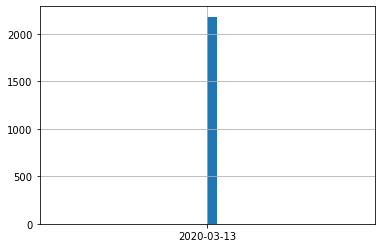

<IPython.core.display.Javascript object>

In [23]:
df.survey_date_latest.hist(bins=30)

## Visualisation of Random Examples
This repulls the data from the cache for selected valid results, and shows what it looks like, including what objects the filter logic discarded.

In [24]:
df_sample = df[df.error.isna()].sample(N_EXAMPLES, random_state=10)
df_sample.T

,14,50,4,3,23,64,50,42,31,58,27,66,29,1,69
id,aac5d6ff-a167-5752-b270-6de0ebcaea32,332ea53c-d43b-52ca-99a7-5c32ce4b2f2d,3e07ecd1-8435-5f59-a9c5-75475361cb8a,8629d65f-4762-55a7-a7fd-acb42dc3876b,191976f6-c842-5e4b-a641-efd985620124,8746a91f-130d-532b-be32-db577bad8186,9d2fd94d-6498-5bd9-86e3-192319b57ee1,7c625723-0902-59eb-9201-5913c8319fe6,6be36b3e-07ee-53a2-8adb-b1df3b811671,41252349-694b-5407-b3c9-0047e3ab8d3f,3700afdc-c4d2-5f9a-ba18-7f1cb617f7d4,520ed1b7-5d09-596f-b895-5542d900907e,1bdada74-38b9-561e-b058-352ff9879503,41e9bfde-a620-5481-b8ba-d2971808a6a4,e55eb166-c9f6-587c-b586-d90d565fab67
geometry,MULTIPOLYGON (((-87.81947532170081 41.73151476...,MULTIPOLYGON (((-87.8206330593022 41.737725362...,MULTIPOLYGON (((-87.83497232917409 41.72189912...,MULTIPOLYGON (((-87.8263606806362 41.721551503...,MULTIPOLYGON (((-87.83747819815019 41.72805311...,MULTIPOLYGON (((-87.8209727557946 41.720092701...,MULTIPOLYGON (((-87.8276365794531 41.723759293...,MULTIPOLYGON (((-87.8381971478221 41.720551225...,MULTIPOLYGON (((-87.8365466044261 41.720926217...,MULTIPOLYGON (((-87.8226825994584 41.720943685...,MULTIPOLYGON (((-87.8284432948706 41.724671460...,MULTIPOLYGON (((-87.8286206097784 41.728862618...,MULTIPOLYGON (((-87.8360945920529 41.719734741...,MULTIPOLYGON (((-87.8391131918731 41.724407671...,MULTIPOLYGON (((-87.8395235081336 41.729997442...
error,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
link,"https://apps.nearmap.com/maps/#/@41.7316211,-8...","https://apps.nearmap.com/maps/#/@41.7379099,-8...","https://apps.nearmap.com/maps/#/@41.7220781,-8...","https://apps.nearmap.com/maps/#/@41.7216926,-8...","https://apps.nearmap.com/maps/#/@41.7285523,-8...","https://apps.nearmap.com/maps/#/@41.7201740,-8...","https://apps.nearmap.com/maps/#/@41.7239405,-8...","https://apps.nearmap.com/maps/#/@41.7207384,-8...","https://apps.nearmap.com/maps/#/@41.7211070,-8...","https://apps.nearmap.com/maps/#/@41.7210153,-8...","https://apps.nearmap.com/maps/#/@41.7248920,-8...","https://apps.nearmap.com/maps/#/@41.7290404,-8...","https://apps.nearmap.com/maps/#/@41.7198404,-8...","https://apps.nearmap.com/maps/#/@41.7245053,-8...","https://apps.nearmap.com/maps/#/@41.7301146,-8..."
version,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1,gen3-winter_sunrise-1.1
survey_date_latest,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13,2020-03-13
primary_building_present,Y,Y,Y,Y,N,N,Y,Y,Y,Y,Y,Y,Y,Y,Y
primary_roof_present,Y,Y,Y,Y,N,N,Y,Y,Y,Y,Y,Y,Y,Y,Y
primary_building_area_sqm,163.3,139.7,470.8,213.9,0.0,0.0,329.7,174.6,220.3,161.4,464.3,349.4,150.7,149.3,240.5
primary_building_area_sqft,1758,1504,5068,2302,0,0,3549,1880,2372,1737,4998,3761,1622,1607,2588


<IPython.core.display.Javascript object>

In [25]:
df_sample.link.values

array(['https://apps.nearmap.com/maps/#/@41.7316211,-87.8192385,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7379099,-87.8205290,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7220781,-87.8347218,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7216926,-87.8261207,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7285523,-87.8365836,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7201740,-87.8207303,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7239405,-87.8274133,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7207384,-87.8380314,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7211070,-87.8364954,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7210153,-87.8224462,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41.7248920,-87.8282055,20.00z,0d/V/20200313',
       'https://apps.nearmap.com/maps/#/@41

<IPython.core.display.Javascript object>

100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


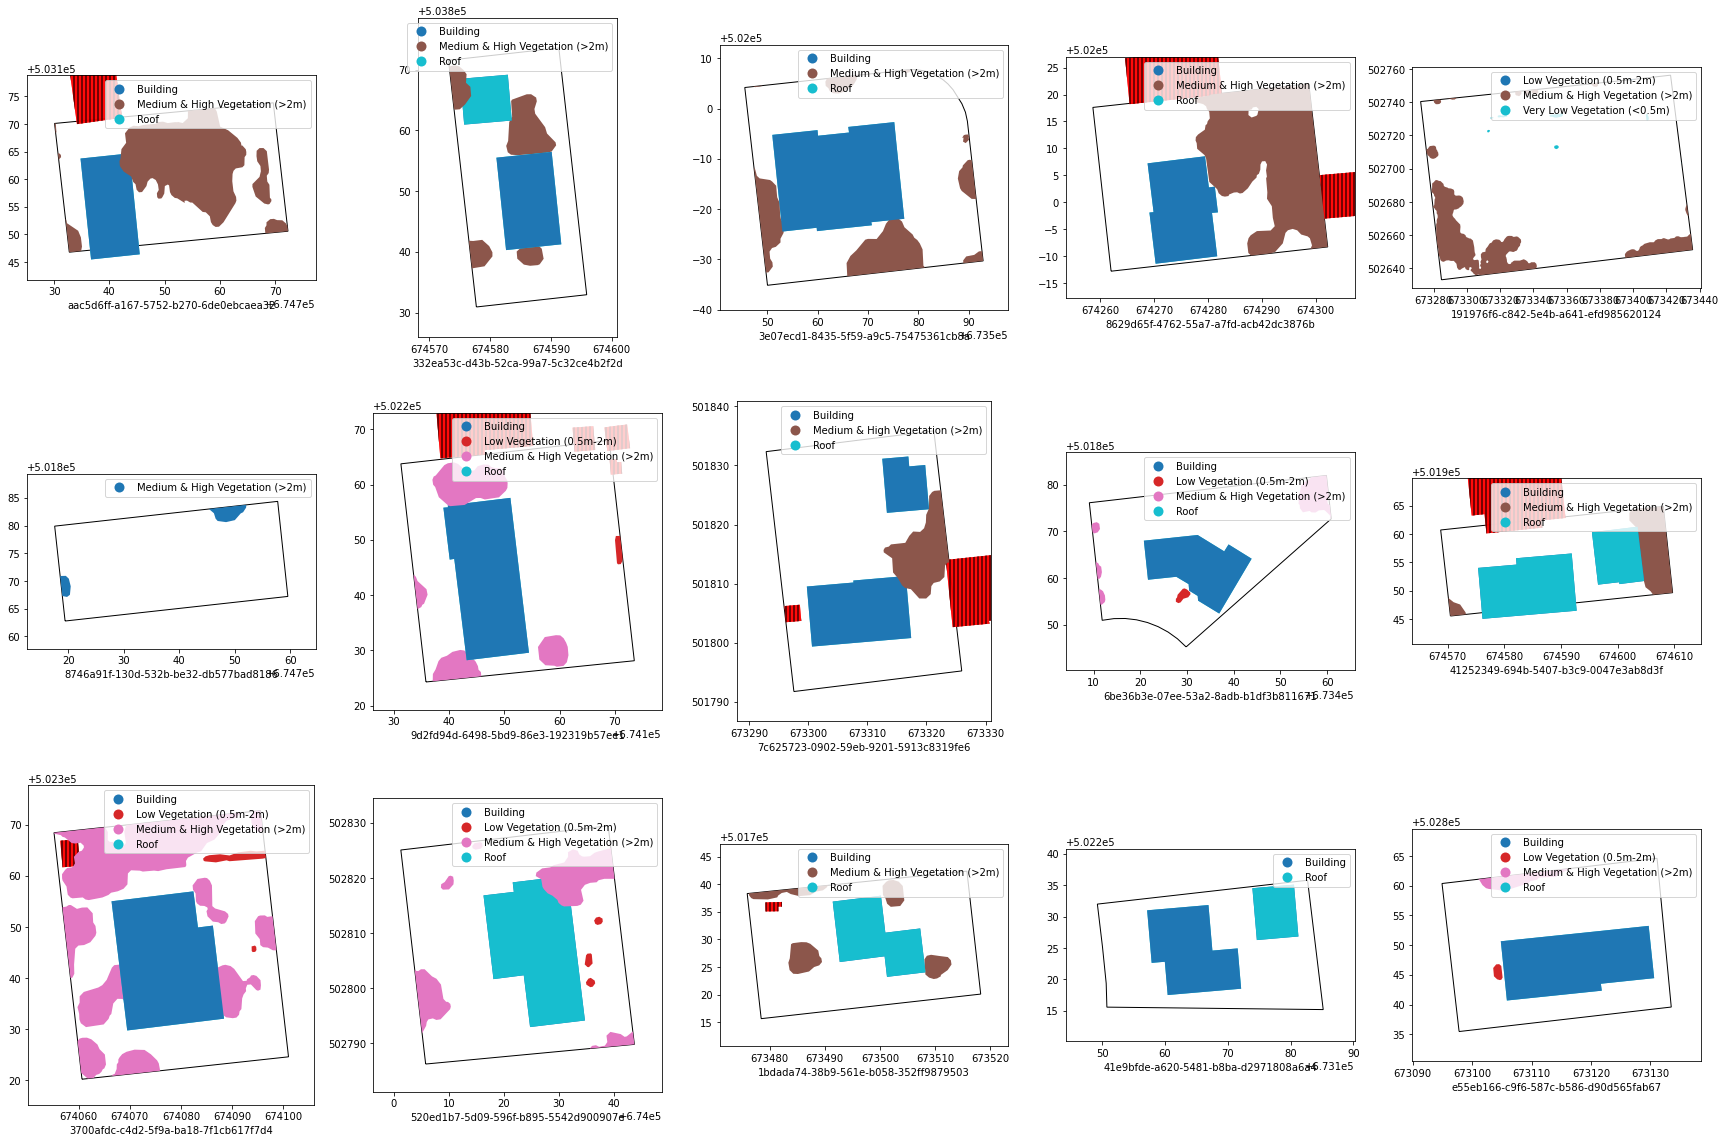

<IPython.core.display.Javascript object>

In [26]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
axes = [ax for row in axes for ax in row]
for i, row in tqdm(parcels_gdf.set_index('id').loc[df_sample.id].reset_index().iterrows(), total=len(df_sample)):
    payload, error = cached_get_payload(row.id, row.geometry_epsg4326, since=SINCE, until=UNTIL)
    
    if not error:
        # Create geo-df
        features_gdf_vis = create_geodataframe(payload, row.geometry).query('classId in @VISUALISATION_IDS')
        
        # Filter features
        features_gdf_keep = filter_features(features_gdf_vis)
        features_gdf_discard = pd.concat((features_gdf_vis, features_gdf_keep)).drop_duplicates(keep=False, subset='id')
        
        if len(features_gdf_discard) > 0:
            # Plot all features to discard
            features_gdf_discard.plot(ax=axes[i], fc="red", alpha=0.8, hatch='|||')
        if len(features_gdf_keep) > 0:
            # Plot remaining features to keep
            features_gdf_keep.plot(ax=axes[i], column="description", legend=True)
        axes[i].set_xlabel(row.id)
    else:
        logging.warning(error)
        axes[i].set_xlabel(error)
    
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - 5, row.geometry.bounds[2] + 5)
    axes[i].set_ylim(row.geometry.bounds[1] - 5, row.geometry.bounds[3] + 5)
